In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap

In [3]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

### Setup directory variables

In [4]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [5]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [6]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

## Load data

In [8]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store', 'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)

In [9]:
df['sex'].unique()

array([2, 1])

In [10]:
(np.sum(df.loc[:,'sex'] == 1)/df.shape[0]) * 100

45.50561797752809

In [11]:
df['ageAtScan1_Years'].mean()

15.364513108614235

In [12]:
df['ageAtScan1_Years'].std()

3.4238927087439732

### Sex

Psychosis_NegativeDisorg 0.20785200486172112 Ttest_indResult(statistic=3.408472434782159, pvalue=0.0006777039497278197)


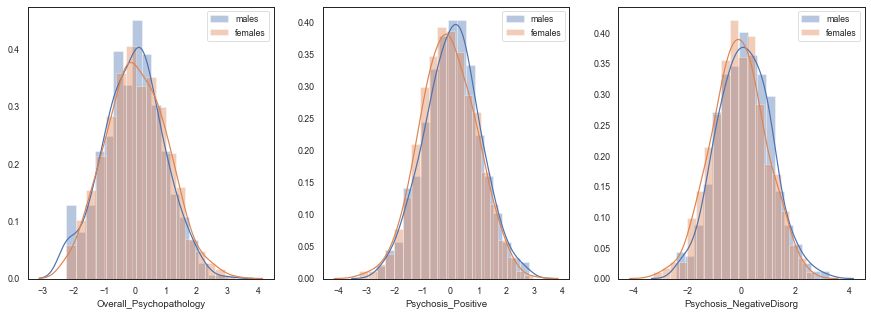

In [13]:
f, ax = plt.subplots(1,3)
f.set_figwidth(15)
f.set_figheight(5)

# sex: 1=male, 2=female
for i, pheno in enumerate(phenos):
    x = df.loc[df['sex'] == 1,pheno]
    y = df.loc[df['sex'] == 2,pheno]
    stats_output = sp.stats.ttest_ind(x,y)
    if stats_output[1] < .05/len(phenos):
        print(pheno, np.mean(x)-np.mean(y), stats_output)
        
    sns.distplot(x, ax=ax[i], label = 'males')
    sns.distplot(y, ax=ax[i], label = 'females')
    ax[i].legend()

f.savefig('symptoms_distributions_sex.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Age

Overall_Psychopathology 0.2918514217420312 2.0470662972970397e-22
Psychosis_Positive -0.0938991817598899 0.0021273929995020203


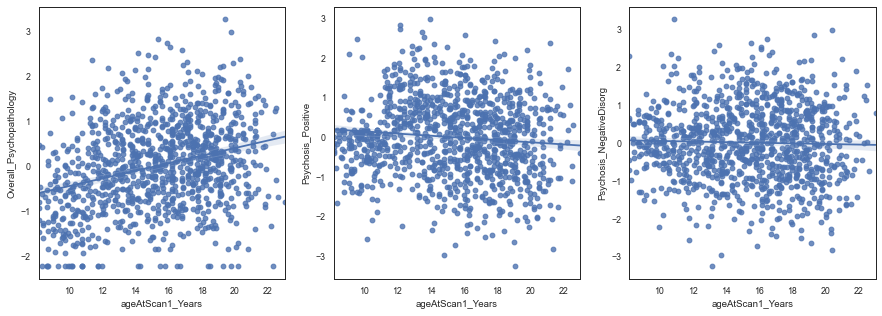

In [14]:
f, ax = plt.subplots(1,3)
f.set_figwidth(15)
f.set_figheight(5)

x = df['ageAtScan1_Years']
# sex: 1=male, 2=female
for i, pheno in enumerate(phenos):
    y = df[pheno]
    r,p = sp.stats.pearsonr(x,y)
    if p < .05/len(phenos):
        print(pheno, r, p)
        
    sns.regplot(x, y, ax=ax[i])
    
f.savefig('symptoms_correlations_age.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)